PCA는 데이터를 새로운 직교 좌표계로 옮겨놓는 선형 차원축소라고 할 수 있다.  


데이터의 차원축소를 위해 인접한 데이터들이 차지하는 작은 영역을 선형관계로 보고,  
이 관계를 잘 유지하는 임베딩 방법을 국소적 선형 임베딩(LLE, locally linear embedding)이라고 부르며, Manifold(다양체) 학습의 일종이다.  
manifold라는 개념은 매우 작은 영역을 관찰할 때 이웃점들 사이의 관계를 유클리드 공간으로 표현할 수 있는 공간을 의미한다.  
manifold는 차원을 갖는데, n차원 manifold는 국소적으로 볼 때 각 점들이 이웃점들과 n차원의 유클리드 공간을 이루는 것이다.  


LLE는 데이터를 이루는 각 지점과 이웃점이 선형관계를 이루고 있다고 가정하고 이들 사이의 선형관계를 찾는다.  
그리고 이 선형관계를 그대로 유지하는 임베딩 공간을 찾아 데이터를 옮겨놓는 것이다.  
임베딩 공간은 인반적으로 원래 데이터 공간보다 낮은 차원이며, 2/3차원이라면 데이터 시각화에 적합할 것이다.  
1. 모든 점에 대해 이웃 지점들을 찾는다.
2. 모든 점에 대해 이웃 지점들과의 선형관계를 찾는다.
3. 앞에서 찾은 선형관계가 유지되는 임베딩 공간을 찾는다.

### Quiz.
LLE를 numpy로만 구현해보자.   

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def make_a_roll(num_data):
    f = 3
    len_unit = np.linspace(0, 1, num_data)
    t = f * len_unit * 3.14    #x, z 좌표가 점점 밖으로 벗어나며 회전하게 하는 매개변수
    
    x = np.sin(t) * (len_unit+0.5) + np.random.randn(num_data)*0.01
    z = np.cos(t) * len_unit + np.random.randn(num_data)*0.01
    y = + np.random.randn(num_data) * 0.3  #큰 범위로 난수를 생성해 띠 형성
    
    #각 데이터의 색 => 시작할 때는 b, 중간에는 g, 마지막에는 r이 강하도록
    r = len_unit
    g = -(2 * (len_unit-0.5))**2 + 1
    b = 1 - len_unit
    
    X = np.array([x, y, z])
    C = np.array([r, g, b])
    return X.T, C.T

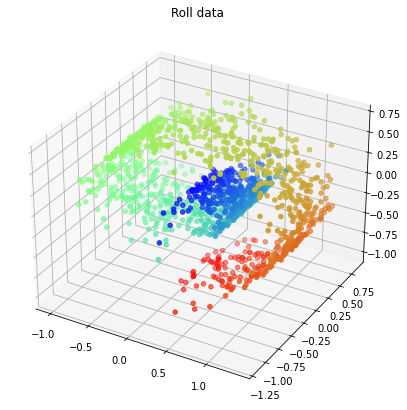

In [2]:
num_data = 1500
X, color = make_a_roll(num_data)

fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection='3d')
ax.scatter3D(X[:,0], X[:,1], X[:,2], color=color)
plt.title('Roll data');

In [5]:
W = np.zeros((num_data, num_data))    #(1500, 1500)

#모든 점에 대해 k개의 이웃 구하기
k = 7
for i in range(num_data):
    Z = X - X[i,:]
    d_vec = (Z ** 2).sum(axis=1)
    neighbor = np.argsort(d_vec)[1:k+1]
    
    Zi = np.matrix(Z[neighbor,:])         #k * n
    Gi = Zi.dot(Zi.T)                     #k * k (nearly singular) 
    correction = np.trace(Gi) * 1e-2      #Gi은 거의 특이행렬이기 때문에 바로 역행렬을 구하면 에러 
    Gi = Gi + np.eye(k) * correction      # => 대각성분 합의 0.01(correction)을 대각성분에 더해 수치오류 피하기
    
    Gi_inv = np.linalg.inv(Gi)
    wi = Gi_inv.dot(np.ones(k,))
    wi /= wi.sum()
    
    W[i,neighbor] = wi

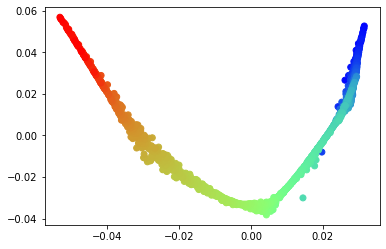

In [10]:
I = np.eye(num_data)
U, sig, Vt = np.linalg.svd(I - W)
Y = Vt.T

#임베딩 공간은 고유벡터의 오른쪽 끝 열들이며, 마지막 고유벡터는 제외 => 2차원 임베딩 공간을 그리기 위해서는 [:,-2], [:,-3] 사용
plt.scatter(Y[:,-2], Y[:,-3], color=color);

### 다양한 manifold 학습 알고리즘
1. Isomap : 가까운 이웃데이터들 사이의 거리관계를 임베딩 공간에서 유지
+ 각 샘플에 대해 가장 가까운 샘플을 연결하여, 그래프를 만들어 측지선(geodesic) 거리의 대소관계를 유지하며 차원축소
+ 측지선 거리는 그래프를 구성하는 노드들 사이의 최단경로를 계산하여 구한다.
2. t-SNE : 데이터 두 쌍 사이의 근접도를 확률분포로 정의하고, 원래 공간과 임베딩 공간에서 이 분포가 최대한 일치하도록 함
+ 통계적 근접점 임베딩 기법(SNE)에 t-분포를 적용하여 개선한 방법
+ m차원의 데이터 인스턴스 x1~xm 이 존재할 때, xi와 xj의 유사도를 조건부 확률로 정의한다.
+ 해당 조건부 확률이 xi가 xj에 대해 갖는 유사도라고 하고, 가우스확률 분포가 xi를 중심으로 놓여있을 때 이웃으로 xj를 선택할 확률이라고 볼 수 있다.
+ 위는 softmax 함수로 확률의 총합은 1이다.

### Quiz.
롤데이터를 manifold 학습을 이용해 2차원 공간으로 옮겨보자.  
sklearn의 manifold 서브모듈에서 LocallyLinearEmbedding, Isomap, TSNE 클래스를 사용할 수 있다.

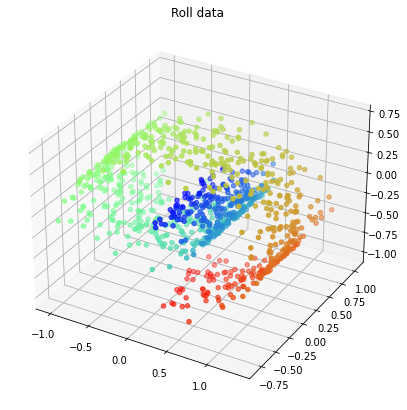

In [11]:
num_data = 1000
X, color = make_a_roll(num_data)

fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection='3d')
ax.scatter3D(X[:,0], X[:,1], X[:,2], color=color)
plt.title('Roll data');

C:\Users\yeonok\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\yeonok\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<Figure size 432x288 with 0 Axes>

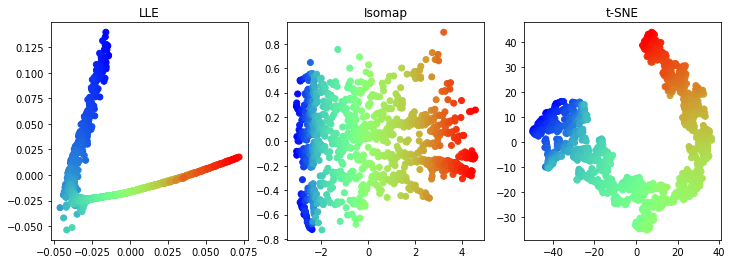

In [13]:
from sklearn.manifold import LocallyLinearEmbedding, Isomap, TSNE

models = {}
models['LLE'] = LocallyLinearEmbedding(n_neighbors=10, n_components=2)
models['Isomap'] = Isomap(n_neighbors=10, n_components=2)
models['t-SNE'] = TSNE(n_components=2)

embeddings = {}
for _, (name, model) in enumerate(models.items()):
    embeddings[name] = model.fit_transform(X)
    
fig = plt.figure()
fig.suptitle('Manifold Learning', fontsize=15)
fig, ax = plt.subplots(1, 3, figsize=(12,4))
for i, (name, model) in enumerate(models.items()):
    ax[i].scatter(embeddings[name][:,0], embeddings[name][:,1], color=color)
    ax[i].set_title(name);

3차원 공간의 데이터가 조금씩 다른 방법으로 2차원 공간으로 옮겨졌다.